# Homework 5: Scene-Dependent Image Segmentation

The goal of this homework is to implement a model that seperates foreground and background objects for a specific scene.  
We will use the highway scene from the Change Detection dataset:  
http://jacarini.dinf.usherbrooke.ca/dataset2014#

![input image](highway/input/in001600.jpg "Title") ![gt image](highway/groundtruth/gt001600.png "Title")

## Task 1: Create a custom (Pytorch) dataset


https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
You need to create a class that inherets from **from torch.utils.data.Dataset** and implements two methods:
- **def \_\_len\_\_(self)**:  returns the length of the dataset
- **def \_\_getitem\_\_(self, idx)**: given an integer idx returns the data x,y
    - x is the image as a float tensor of shape: $(3,H,W)$ 
    - y is the label image as a mask of shape: $(H,W)$ each pixel should contain the label 0 (background) or 1 (foreground). It is recommended to use the type torch.long
    
**Tips**:
- The first 470 images are not labeled. Just ignore these images. 
- If possible load all images into memory or evene directly to GPU to increase speed.
- You can change the resolution to fit your model or your memory
- Add data augmentation to increase the data size

## Task 2: Create a custom Segmentation Model

- input: a batch of images $(B,3,H,W)$ 
- output: a batch of pixel-wise class predictions $(B,C,H,W)$, where $C=2$

Tips:
- It is recommended to use a Fully-Convolutional Neural Network, because it flexible to the input and output resolution.
- Use Residual Blocks with convolutional layers.
- Base your model on established segmentation models:
    - U-Net: https://arxiv.org/abs/1505.04597
    - Deeplab: https://arxiv.org/abs/1606.00915

## Task 3: Create a training loop
- split data into training and test data, e.g. 80% training data and 20% test data using your custom dataset.
- Create a Dataloader for your custom datasets 
- Define a training loop for a single epoch:
    - forward pass
    - Loss function, e.g. cross entropy
    - optimizer 
    - backward pass
    - logging
- Define validation loop:
    - forward pass
    - extract binary labels, e.g. threshold or argmax for each pixel.
    - compute evaluation metrics: Accuracy, Precision, Recall and Intersection over Union for each image

## Task 4: Small Report of your model and training
- visualize training and test error over each epoch
- report the evaluation metrics of the final model

In [143]:
import cv2 as cv
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"TORCH: using device: {device}")

TORCH: using device: cpu


load all images

In [144]:
img_indices = range(471,1701)

source_inputs = [cv.imread(f"highway/input/in00{i:04d}.jpg", )[:,:,::-1] for i in img_indices]
source_gts = [cv.imread(f"highway/groundtruth/gt00{i:04d}.png",0) for i in img_indices]

# downsize images
dim = (53, 40) # width, height
source_inputs = np.array([cv.resize(img, dim, interpolation = cv.INTER_AREA) for img in source_inputs])
source_gts = np.array([cv.resize(img, dim, interpolation = cv.INTER_AREA) > 0 for img in source_gts])

(40, 53, 3)


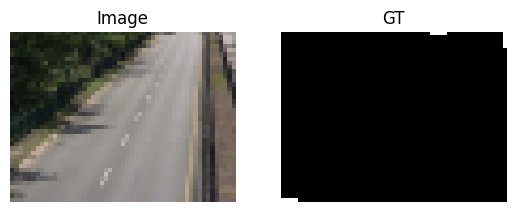

In [145]:
img = source_inputs[0]
gt = source_gts[0]
print(img.shape)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(gt, cmap="gray")
plt.axis("off")
plt.title("GT")
plt.show()

## data augmentation
changed brightness

In [146]:
def change_brightness_random(img):
    b_change = np.random.randint(-100, 100)

    b_img = cv.convertScaleAbs(img, beta=b_change)

    return b_img

In [147]:
b_inputs = [change_brightness_random(img) for img in source_inputs]
b_inputs = np.array(b_inputs)

(40, 53, 3)


Text(0.5, 1.0, 'Image')

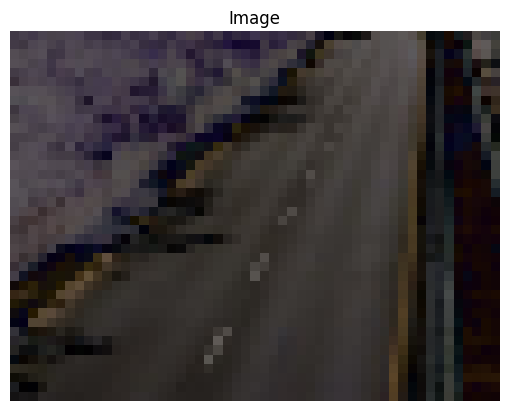

In [148]:
img = b_inputs[0,:,:,:]
print(img.shape)
plt.figure()
#plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")
plt.title("Image")

change contrast

In [149]:
def change_contrast_random(img):
    #b_change = np.random.uniform(0.2, 2)
    b_change = 0.2

    b_img = cv.convertScaleAbs(img, alpha=b_change)

    return b_img

In [150]:
c_inputs = [change_contrast_random(img) for img in source_inputs]
c_inputs = np.array(c_inputs)

Text(0.5, 1.0, 'Image')

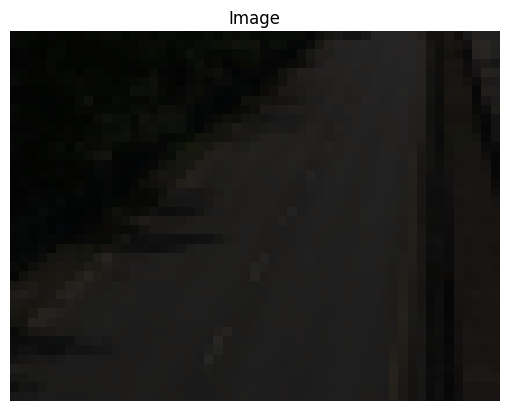

In [151]:
img = c_inputs[0,:,:,:]
#print(img.shape)
plt.figure()
#plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")
plt.title("Image")

train, test and eval split

In [152]:
augm_input = [source_inputs, b_inputs, c_inputs]

inputs = np.concatenate(augm_input, axis=0)
gts = np.concatenate([source_gts]*len(augm_input), axis=0)

inputs = inputs.transpose(0,3,1,2)
#gts = gts[:,np.newaxis,:,:]

print(inputs.shape)
print(gts.shape)

(3690, 3, 40, 53)
(3690, 40, 53)


In [153]:
train_input, test_input, train_gt, test_gt = train_test_split(inputs, gts, train_size=.8, shuffle=True)
train_input, eval_input, train_gt, eval_gt = train_test_split(train_input, train_gt, test_size=.1, shuffle=True)
print(f"train_input: {train_input.shape}")
print(f"train_gt: {train_gt.shape}")
print()
print(f"eval_input: {eval_input.shape}")
print(f"eval_gt: {eval_gt.shape}")
print()
print(f"test_input: {test_input.shape}")
print(f"test_gt: {test_gt.shape}")

train_input: (2656, 3, 40, 53)
train_gt: (2656, 40, 53)

eval_input: (296, 3, 40, 53)
eval_gt: (296, 40, 53)

test_input: (738, 3, 40, 53)
test_gt: (738, 40, 53)


In [154]:
class SegmentDataset(Dataset):
    def __init__(self, inputs, gts) -> None:
        super().__init__()
        self.inputs = inputs
        self.gts = gts

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        input = torch.tensor(self.inputs[index], dtype=torch.float32, requires_grad=True)
        gt = torch.tensor(self.gts[index], dtype=torch.long)

        return input, gt

In [155]:
loaders = {
    'train' : DataLoader(SegmentDataset(train_input, train_gt),
                        batch_size=32,
                        shuffle=True,
                        #num_workers=1
                        ),

    'eval'  : DataLoader(SegmentDataset(eval_input, eval_gt),
                        batch_size=32,
                        shuffle=False,
                        #num_workers=1
                        ),

    'test'  : DataLoader(SegmentDataset(test_input, test_gt),
                        batch_size=32,
                        shuffle=False,
                        #num_workers=1
                        ),
}

## Model

In [156]:
class ResidualBlock(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    self.batch1 = nn.BatchNorm2d(out_channels)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
    self.batch2 = nn.BatchNorm2d(out_channels)
    self.relu2 = nn.ReLU()
    if in_channels != out_channels:
        self.matching_conv = nn.Conv2d(in_channels, out_channels, 1)  # 1x1 conv
    else:
        self.matching_conv = nn.Identity()


  def forward(self,x):
    residual = self.matching_conv(x)
    out = self.conv1(x)
    out = self.batch1(out)
    out = self.relu1(out)
    out = self.conv2(out)
    out = self.batch2(out)
    out += residual
    out = self.relu2(out)
    return out
  
class DeConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=5, stride=1, padding=1):
    super().__init__()
    self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
    self.batch = nn.BatchNorm2d(out_channels)
    self.dropout = nn.Dropout2d(0.25)
    self.res = ResidualBlock(out_channels*2, out_channels)

  def forward(self, x, residual):
    out = self.deconv(x)
    out = self.batch(out)
    out = torch.concatenate([residual, out], axis=1)
    out = self.dropout(out)
    out = self.res(out)
    return out
    
class ResUNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.dropout = nn.Dropout2d(0.25)

    self.res1 = ResidualBlock(3, 16)
    self.maxpool1 = nn.MaxPool2d(3, stride=1)

    self.res2 = ResidualBlock(16, 32)
    self.maxpool2 = nn.MaxPool2d(3, stride=1)

    self.res3 = ResidualBlock(32, 32)
     
    self.deconv1 = DeConvBlock(32, 32)
    self.deconv2 = DeConvBlock(32, 16)

    self.output = nn.Conv2d(16,2, kernel_size=3, stride=1, padding=1)
    self.act = nn.Sigmoid()

  def forward(self,x):
     conv1 = self.res1(x) 
     pool1 = self.maxpool1(conv1) # -2 38x51
     pool1 = self.dropout(pool1)

     conv2 = self.res2(pool1)
     pool2 = self.maxpool2(conv2) # -2 36x49
     pool2 = self.dropout(pool2)

     conv3 = self.res3(pool2)

     deconv1 = self.deconv1(conv3, conv2) # +2 38x51

     deconv2 = self.deconv2(deconv1, conv1) # +2 40x53

     output = self.output(deconv2)
     output = self.act(output)

     return output
  
  @torch.no_grad()
  def predict(self, x):
    y = self.forward(x)
    output = torch.max(y, dim=1)

    return output


## Training

In [157]:
def train_epoch(model: torch.nn.Module, train_loader: DataLoader, f_loss: torch.nn.modules.loss, optimizer: torch.optim.Optimizer):
    epoch_loss = []

    for _, (batch_img, batch_target) in enumerate(train_loader):
        output = model.forward(batch_img)

        loss = f_loss(output, batch_target)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        with torch.no_grad():
            epoch_loss += [loss.item()]

    return np.array(epoch_loss).mean()

@torch.no_grad()
def test(model: torch.nn.Module, test_loader: DataLoader):
    model.eval()
    true_labels = []
    pred_labels = []
    for _, (batch_img, batch_targets) in enumerate(test_loader):
        y = model.predict(batch_img)

        pred_labels.append(y.numpy())
        true_labels.append(batch_targets.numpy())

    return np.array(pred_labels).flatten(), np.array(true_labels).flatten()

@torch.no_grad()
def eval(model: torch.nn.Module, eval_loader: DataLoader, f_loss: torch.nn.modules.loss):
    model.eval()
    eval_loss = []

    for _, (batch_img, batch_targets) in enumerate(eval_loader):
        y = model.forward(batch_img)

        loss = f_loss(y, batch_targets)
        eval_loss += [loss.item()]

    eval_loss = np.array(eval_loss).mean()

    return eval_loss

def train(model: torch.nn.Module, loaders: dict[DataLoader], f_loss: torch.nn.modules.loss, optimizer: torch.optim.Optimizer, num_epochs=20):
    model.train()

    train_loss = []
    eval_loss = []

    for epoch in range(num_epochs):
        epoch_train_loss = train_epoch(model, loaders["train"], f_loss, optimizer)

        with torch.no_grad():
            epoch_test_loss = eval(model, loaders["eval"], f_loss)

            print(f"epoch: {epoch} train_loss: {round(epoch_train_loss, 2)} "
                  f"test_loss: {round(epoch_test_loss, 2)}")

            train_loss.append(epoch_train_loss)
            eval_loss.append(epoch_test_loss)

    return train_loss, eval_loss


In [158]:
segmodel = ResUNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(segmodel.parameters())

train_loss, eval_loss = train(segmodel, loaders, criterion, optimizer, num_epochs=20)

epoch: 0 train_loss: 0.46 test_loss: 0.43
epoch: 1 train_loss: 0.42 test_loss: 0.43


KeyboardInterrupt: 